In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd

# Read data from the specified URL
activities_data = pd.read_csv('https://raw.githubusercontent.com/Redback-Operations/redback-fit-sports-performance/main/Cycling%20Analysis/data/extended_activities_TRI001.csv')

# Extract only 'Cycling' sessions from the dataset
cycling_data = activities_data[activities_data['Activity Type'] == 'Ride']


In [2]:
# Import necessary libraries for plotting
import matplotlib.pyplot as plt

def plot_prediction_results(actual_values, predicted_values, model_name):
    """
    Plot the actual vs predicted values.

    Parameters:
        actual_values (array-like): Actual values.
        predicted_values (array-like): Predicted values.
        model_name (str): Name of the model for the plot title.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(actual_values, predicted_values, alpha=0.7, color='blue', label='Predictions')
    plt.plot([actual_values.min(), actual_values.max()], [actual_values.min(), actual_values.max()], 'k--', lw=2)  # Diagonal line for reference
    plt.xlabel('Actual FTP', fontsize=12)
    plt.ylabel('Predicted FTP', fontsize=12)
    plt.title(f'Actual vs Predicted FTP: {model_name}', fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()



In [3]:
def reduce_columns(data):
    """
    Remove unnecessary columns from the dataset.

    Parameters:
        data (pandas.DataFrame): Input data with columns to be reduced.

    Returns:
        pandas.DataFrame: Data with unnecessary columns removed.
    """
    columns_to_remove = [
        'Activity ID',
        'Activity Name',
        'Activity Type',
        'Commute',
        'Activity Gear',
        'Filename',
        'Dirt Distance',
        'Total Steps',
        'Bike Weight'
    ]

    reduced_data = data.drop(columns_to_remove, axis=1)
    return reduced_data


**Based on the five days below, the FTP values is spread out throughout the dataset. Models trained
using 1 day power curve.**

In [4]:
# Add FTP data to the dataframe
ftp_data = pd.DataFrame({
    'Date': ['2017-06-28', '2020-09-18', '2021-01-31', '2022-09-23', '2023-01-05'],
    'FTP': [222 * 0.95, 238 * 0.95, 245 * 0.95, 262 * 0.95, 266 * 0.95]
})

# Reduce unnecessary columns in the data
data = reduce_columns(cycling_data)

# Convert 'Date' columns to datetime
data['Activity Date'] = pd.to_datetime(data['Activity Date'])
ftp_data['Date'] = pd.to_datetime(ftp_data['Date'])


In [5]:
ftp_data

,Date,FTP
0,2017-06-28,210.90
1,2020-09-18,226.10
2,2021-01-31,232.75
3,2022-09-23,248.90
4,2023-01-05,252.70


In [6]:
# Create a continuous date range DataFrame
date_range = pd.date_range(start=ftp_data['Date'].min(), end=ftp_data['Date'].max())
all_dates = pd.DataFrame({'Date': date_range})

# Merge FTP test data with the date range DataFrame
all_dates_with_ftp = pd.merge(all_dates, ftp_data, on='Date', how='left')

# Interpolate missing FTP values
all_dates_with_ftp['FTP'] = all_dates_with_ftp['FTP'].interpolate(method='linear')

# Merge interpolated FTP data with the original workout data
ftp_values = pd.merge_asof(data.sort_values('Activity Date'), all_dates_with_ftp, left_on='Activity Date', right_on='Date', direction='backward')

# Drop the extra 'Date' column
ftp_values = ftp_values.drop(columns=['Date'])


In [7]:
# List out columns from dataset after merge
ftp_values.columns

Index(['Activity Date', 'Elapsed Time', 'Max Heart Rate', 'Relative Effort',
       'Athlete Weight', 'Moving Time', 'Distance', 'Max Speed',
       'Average Speed', 'Elevation Gain', 'Elevation Loss', 'Elevation Low',
       'Elevation High', 'Max Grade', 'Average Grade', 'Max Cadence',
       'Average Cadence', 'Average Heart Rate', 'Average Watts', 'Calories',
       'Average Temperature', 'Total Work', 'Perceived Exertion',
       'Weighted Average Power', 'Power Count', 'Prefer Perceived Exertion',
       'Perceived Relative Effort', 'From Upload', 'Grade Adjusted Distance',
       'Bike', 'Gear', 'Flagged', 'Average Elapsed Speed', 'Maximum Pace 5s',
       'Maximum Pace 10s', 'Maximum Pace 30s', 'Maximum Pace 1.0min',
       'Maximum Pace 5.0min', 'Maximum Pace 10.0min', 'Maximum Pace 20.0min',
       'Maximum Pace 30.0min', 'Maximum Pace 1.0 hr', 'Maximum Pace 1.5 hr',
       'Maximum Pace 2.0 hr', 'Maximum Power 5s', 'Maximum Power 10s',
       'Maximum Power 30s', 'Maximum Po

In [8]:
#Selecting power curve features as input to model
input_cols = ['Maximum Power 5s', 'Maximum Power 10s',
       'Maximum Power 30s', 'Maximum Power 1.0min', 'Maximum Power 5.0min',
       'Maximum Power 10.0min', 'Maximum Power 20.0min',
       'Maximum Power 30.0min', 'Maximum Power 1.0 hr', 'Maximum Power 1.5 hr',
       'Maximum Power 2.0 hr']
ftp_values[input_cols]  # Features

,Maximum Power 5s,Maximum Power 10s,Maximum Power 30s,Maximum Power 1.0min,Maximum Power 5.0min,Maximum Power 10.0min,Maximum Power 20.0min,Maximum Power 30.0min,Maximum Power 1.0 hr,Maximum Power 1.5 hr,Maximum Power 2.0 hr
0,439.2,412.9,342.1,221.2,162.2,136.3,120.8,109.8,105.4,0.0,0.0
1,386.2,342.1,236.1,184.3,150.6,131.4,122.1,120.3,115.6,0.0,0.0
2,422.6,390.5,265.1,213.3,146.2,135.1,127.5,125.5,110.2,104.7,0.0
3,473.0,452.0,303.1,262.0,161.9,146.7,139.7,134.0,112.3,0.0,0.0
4,404.0,342.9,243.9,208.3,134.7,124.0,119.4,115.5,99.8,96.9,0.0
...,...,...,...,...,...,...,...,...,...,...,...
176,392.2,358.3,293.4,271.2,246.5,242.5,236.1,229.8,118.3,0.0,0.0
177,329.6,306.4,291.5,260.2,215.3,201.9,188.0,176.2,0.0,0.0,0.0
178,536.8,417.6,269.0,236.5,211.2,200.0,185.6,181.7,169.4,167.0,166.9
179,278.4,252.3,211.8,194.2,174.5,170.5,166.6,164.7,159.8,156.5,151.2


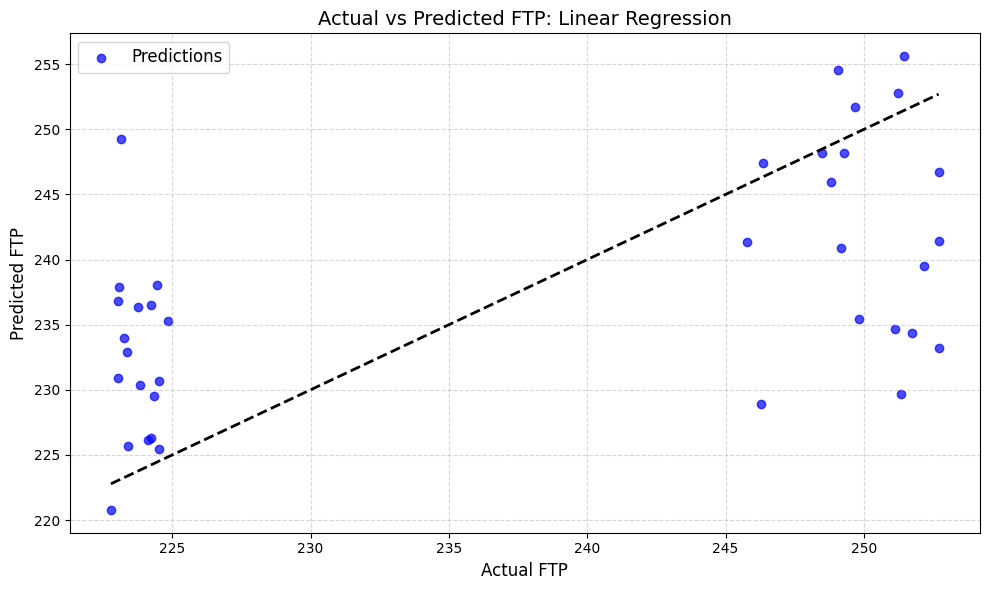

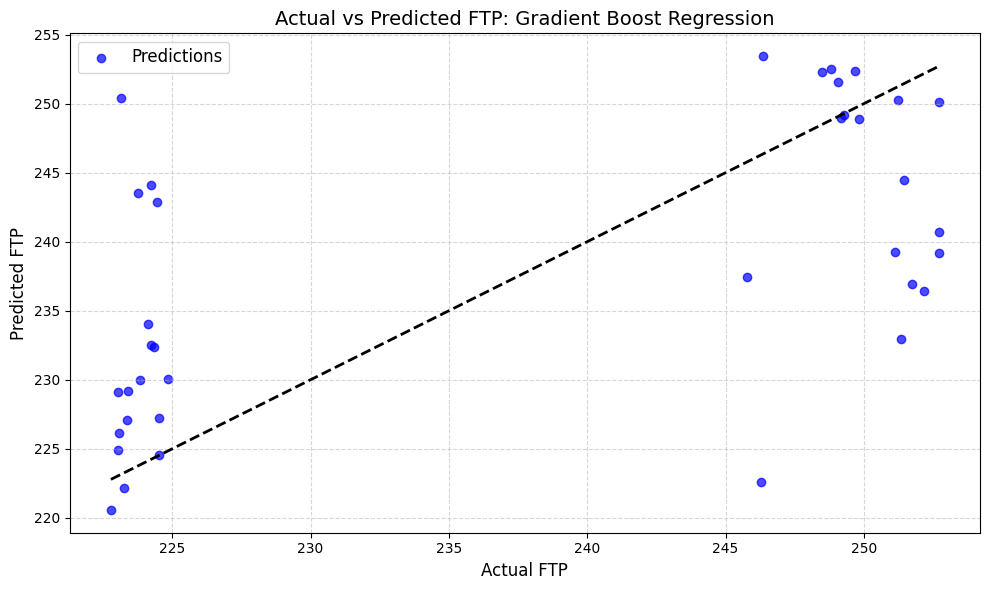

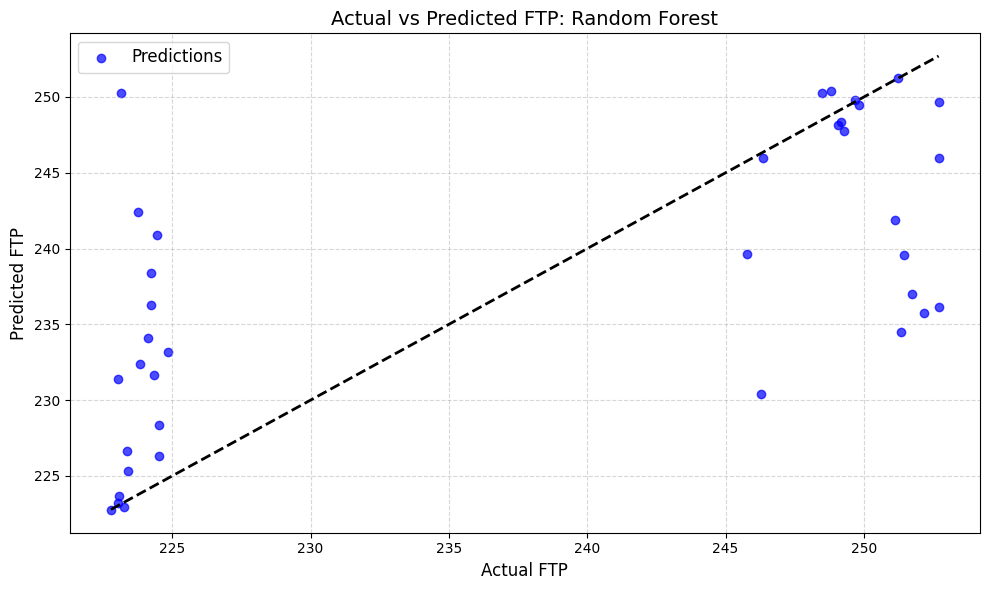

,Model,MSE,R² Score
0,Linear Regression,121.4227,0.3033
1,Gradient Boost Regression,117.0918,0.3281
2,Random Forest,100.6615,0.4224


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the data
data = ftp_values

# Drop any rows where FTP is NaN
data = data.dropna(subset=['FTP'])
data = data.drop(['Activity Date'], axis=1)
data = data.fillna(0)

# Define features (X) and target variable (y)
X = data[input_cols]
y = data['FTP']

# Initialize lists to store results
model_names = []
mse_scores = []
r2_scores = []

# Define a function to evaluate and store results
def evaluate_model(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plot_prediction_results(y_test, y_pred, name)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    model_names.append(name)
    mse_scores.append(mse)
    r2_scores.append(r2)

# Initialize models
models = [
    ("Linear Regression", LinearRegression()),
    ("Gradient Boost Regression", GradientBoostingRegressor()),
    ("Random Forest", RandomForestRegressor())
]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Evaluate each model
for name, model in models:
    evaluate_model(model, name)

# Create a DataFrame to store results
results_df = pd.DataFrame({
    "Model": model_names,
    "MSE": mse_scores,
    "R² Score": r2_scores
})

# Result DataFrame

results_df["MSE"] = results_df["MSE"].apply(lambda x: f"{x:.4f}")
results_df["R² Score"] = results_df["R² Score"].apply(lambda x: f"{x:.4f}")

# Highlight the best-performing model(s)
highlighted_df = results_df.style.apply(lambda x: ['background: lightgreen;color: black' if x.name == 'MSE' and value == x.min() else 'background: lightblue; color: black' if x.name == 'R² Score' and value == x.max() else '' for value in x])

# Print the DataFrame
display(highlighted_df)




**In Summary for this method,**  
*The linear regression model shows a moderate fit with an MSE of 121.42 and R² of 0.303, indicating room for improvement. The gradient boost regressor model yields a slight enhancement with MSE of 118.26 and R² of 0.321. Notably, the random forest regressor model demonstrates improved performance with an MSE of 103.46 and R² of 0.407 compared to the other models.*

**Now train the model based on 30 day maximum power instead of 1 day power curve.**

In [10]:
data = activities_data

# Filter for 'Ride' activities
data = data[data['Activity Type'] == 'Ride']


data = reduce_columns(data)

# Convert 'Activity Date' to datetime and set as index
data['Activity Date'] = pd.to_datetime(data['Activity Date'])
data.set_index('Activity Date', inplace=True)

# Sort dataframes by date
data.sort_index(inplace=True)


# Identify 'Maximum Power xx' fields and calculate 30-day rolling maximum
for column in data.columns:
    if column.startswith('Maximum Power'):
        # Calculate 30-day rolling max
        rolling_max = data[column].rolling(window='30D', min_periods=1).max()

        # Replace original column or create a new one
        new_column_name = '30 Day ' + column
        data[new_column_name] = rolling_max

# Resetting the index
data.reset_index(inplace=True)

# Droping the old 'Maximum Power xx' fields
data.drop(columns=[col for col in data.columns if col.startswith('Maximum Power')], inplace=True)


In [11]:
# Create a continuous date range DataFrame
date_range = pd.date_range(start=ftp_data['Date'].min(), end=ftp_data['Date'].max())
all_dates = pd.DataFrame({'Date': date_range})

# Merge FTP test data with the date range DataFrame
all_dates_with_ftp = pd.merge(all_dates, ftp_data, on='Date', how='left')

# Interpolate missing FTP values
all_dates_with_ftp['FTP'] = all_dates_with_ftp['FTP'].interpolate(method='linear')

# Merge interpolated FTP data with the original workout data
ftp_values = pd.merge_asof(data.sort_values('Activity Date'), all_dates_with_ftp, left_on='Activity Date', right_on='Date', direction='backward')

# Drop the extra 'Date' column
ftp_values = ftp_values.drop(columns=['Date'])


In [12]:
#List out columns from dataset after merge
ftp_values.columns

Index(['Activity Date', 'Elapsed Time', 'Max Heart Rate', 'Relative Effort',
       'Athlete Weight', 'Moving Time', 'Distance', 'Max Speed',
       'Average Speed', 'Elevation Gain', 'Elevation Loss', 'Elevation Low',
       'Elevation High', 'Max Grade', 'Average Grade', 'Max Cadence',
       'Average Cadence', 'Average Heart Rate', 'Average Watts', 'Calories',
       'Average Temperature', 'Total Work', 'Perceived Exertion',
       'Weighted Average Power', 'Power Count', 'Prefer Perceived Exertion',
       'Perceived Relative Effort', 'From Upload', 'Grade Adjusted Distance',
       'Bike', 'Gear', 'Flagged', 'Average Elapsed Speed', 'Maximum Pace 5s',
       'Maximum Pace 10s', 'Maximum Pace 30s', 'Maximum Pace 1.0min',
       'Maximum Pace 5.0min', 'Maximum Pace 10.0min', 'Maximum Pace 20.0min',
       'Maximum Pace 30.0min', 'Maximum Pace 1.0 hr', 'Maximum Pace 1.5 hr',
       'Maximum Pace 2.0 hr', '30 Day Maximum Power 5s',
       '30 Day Maximum Power 10s', '30 Day Maximum Po

In [13]:
#Selecting power curve features as input to model
input_cols = ['30 Day Maximum Power 5s',
       '30 Day Maximum Power 10s', '30 Day Maximum Power 30s',
       '30 Day Maximum Power 1.0min', '30 Day Maximum Power 5.0min',
       '30 Day Maximum Power 10.0min', '30 Day Maximum Power 20.0min',
       '30 Day Maximum Power 30.0min', '30 Day Maximum Power 1.0 hr',
       '30 Day Maximum Power 1.5 hr', '30 Day Maximum Power 2.0 hr']
ftp_values[input_cols]  # Features

,30 Day Maximum Power 5s,30 Day Maximum Power 10s,30 Day Maximum Power 30s,30 Day Maximum Power 1.0min,30 Day Maximum Power 5.0min,30 Day Maximum Power 10.0min,30 Day Maximum Power 20.0min,30 Day Maximum Power 30.0min,30 Day Maximum Power 1.0 hr,30 Day Maximum Power 1.5 hr,30 Day Maximum Power 2.0 hr
0,439.2,412.9,342.1,221.2,162.2,136.3,120.8,109.8,105.4,0.0,0.0
1,439.2,412.9,342.1,221.2,162.2,136.3,122.1,120.3,115.6,0.0,0.0
2,439.2,412.9,342.1,221.2,162.2,136.3,127.5,125.5,115.6,104.7,0.0
3,473.0,452.0,342.1,262.0,162.2,146.7,139.7,134.0,115.6,104.7,0.0
4,473.0,452.0,342.1,262.0,162.2,146.7,139.7,134.0,115.6,104.7,0.0
...,...,...,...,...,...,...,...,...,...,...,...
176,481.4,443.8,321.2,291.0,253.3,247.1,240.6,237.4,193.7,177.1,170.5
177,481.4,443.8,321.2,291.0,253.3,247.1,240.6,237.4,193.7,177.1,170.5
178,536.8,443.8,321.2,275.8,253.3,247.1,240.6,237.4,179.8,172.9,170.5
179,278.4,252.3,211.8,194.2,174.5,170.5,166.6,164.7,159.8,156.5,151.2


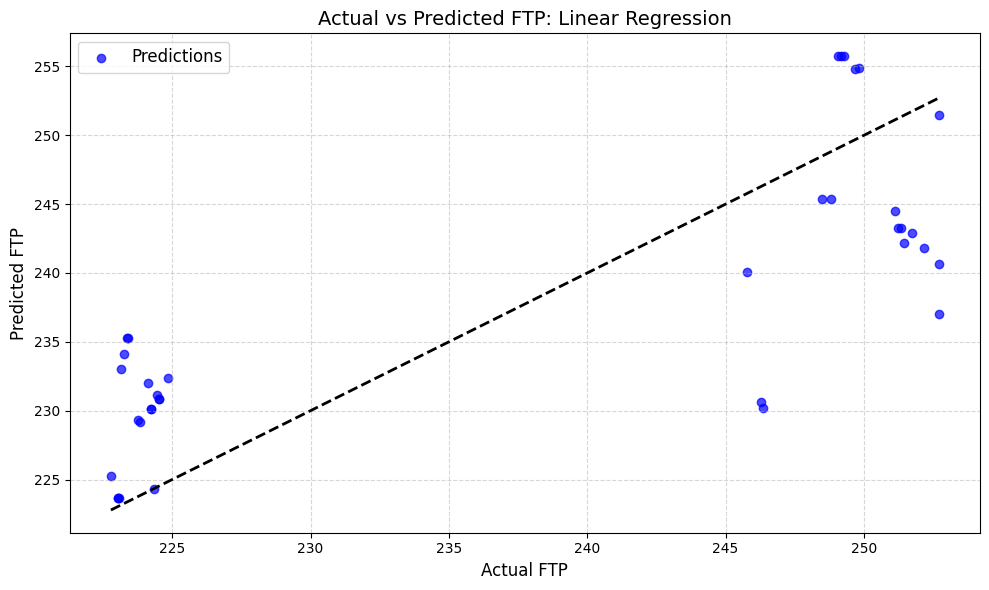

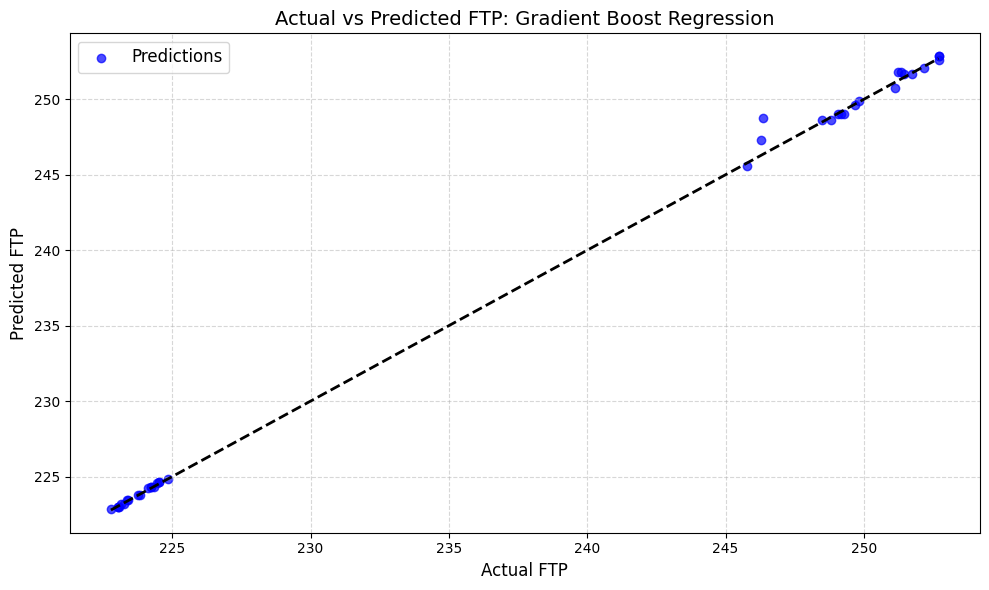

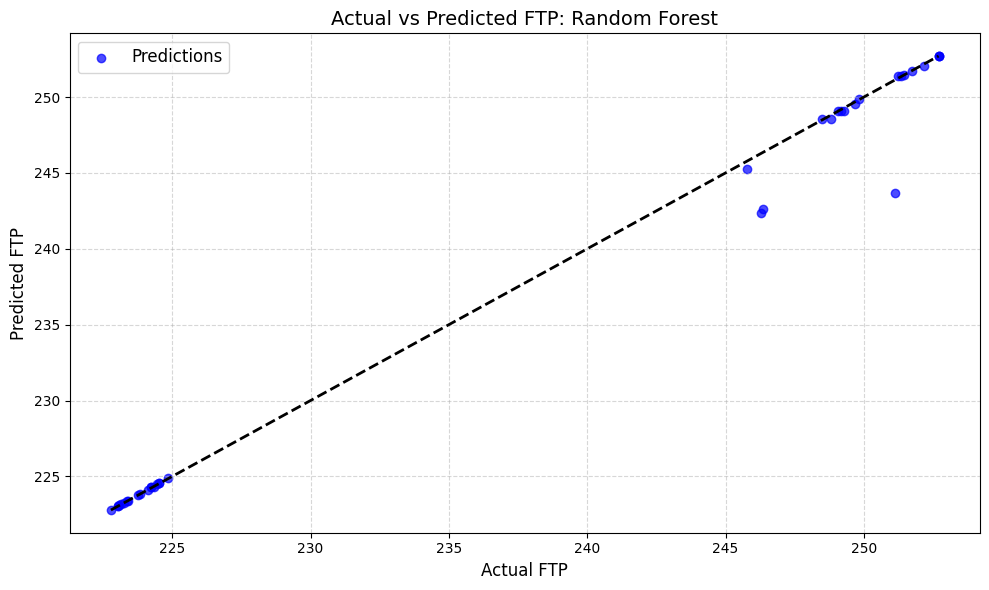

,Model,MSE,R² Score
0,Linear Regression,66.5691,0.6180
1,Gradient Boost Regression,0.2131,0.9988
2,Random Forest,2.3223,0.9867


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the data
data = ftp_values

# Drop any rows where FTP is NaN
data = data.dropna(subset=['FTP'])
data = data.drop(['Activity Date'], axis=1)
data = data.fillna(0)

# Define features (X) and target variable (y)
X = data[input_cols]
y = data['FTP']

# Initialize lists to store results
model_names = []
mse_scores = []
r2_scores = []

# Define a function to evaluate and store results
def evaluate_model(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plot_prediction_results(y_test, y_pred, name)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    model_names.append(name)
    mse_scores.append(mse)
    r2_scores.append(r2)

# Initialize models
models = [
    ("Linear Regression", LinearRegression()),
    ("Gradient Boost Regression", GradientBoostingRegressor()),
    ("Random Forest", RandomForestRegressor())
]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Evaluate each model
for name, model in models:
    evaluate_model(model, name)

# Create a DataFrame to store results
results_df = pd.DataFrame({
    "Model": model_names,
    "MSE": mse_scores,
    "R² Score": r2_scores
})

# Result DataFrame

results_df["MSE"] = results_df["MSE"].apply(lambda x: f"{x:.4f}")
results_df["R² Score"] = results_df["R² Score"].apply(lambda x: f"{x:.4f}")

# Highlight the best-performing model(s)
highlighted_df = results_df.style.apply(lambda x: ['background: lightgreen;color: black' if x.name == 'MSE' and value == x.min() else 'background: lightblue; color: black' if x.name == 'R² Score' and value == x.max() else '' for value in x])

# Print the DataFrame
display(highlighted_df)




**In Summary for this method**,  
- Gradient Boost Model: Exceptionally accurate with minimal errors. MSE of 66.569 and R^2 score of 0.61.
- Random Forest: Highly accurate, minor errors. MSE of 0.057 and R^2 score of 0.999.
- Linear Regression: Moderate accuracy, decent fit. MSE of 2.795 and R^2 score of 0.984.

**Using different approach to calculate FTP**  
*The below code calculates an estimates Functional Threshold Power (FTP) using data from two specific columns(maximum power 20 min and maximum power 1 hr), selecting the higher of the two values as the FTP*

In [15]:
# Use activites data which is the source data
data = activities_data

# Extract only 'Cycling' sessions from the dataset
data = data[data['Activity Type'] == 'Ride']
data = reduce_columns(data)

# Iterate through the dataset row by row
for index, row in data.iterrows():
    # Calculate FTP based on 'Maximum Power 20.0min' column
    FTP_20min = row['Maximum Power 20.0min'] * 0.95

    # Take the maximum of FTP_20min and 'Maximum Power 1hr' column
    data.at[index, 'FTP'] = max(FTP_20min, row['Maximum Power 1.0 hr'])

# Print the DataFrame to verify the new FTP column
data.head(5)


,Activity Date,Elapsed Time,Max Heart Rate,Relative Effort,Athlete Weight,Moving Time,Distance,Max Speed,Average Speed,Elevation Gain,...,Maximum Power 30s,Maximum Power 1.0min,Maximum Power 5.0min,Maximum Power 10.0min,Maximum Power 20.0min,Maximum Power 30.0min,Maximum Power 1.0 hr,Maximum Power 1.5 hr,Maximum Power 2.0 hr,FTP
216,"13 Dec 2019, 01:46:07",3859,139.0,11.0,84.0,3811.0,22970.800781,10.2,5.989,126.0,...,342.1,221.2,162.2,136.3,120.8,109.8,105.4,0.0,0.0,114.760
217,"20 Dec 2019, 23:05:01",4852,133.0,12.0,84.0,4693.0,29658.500000,14.1,6.343,89.0,...,236.1,184.3,150.6,131.4,122.1,120.3,115.6,0.0,0.0,115.995
218,"21 Dec 2019, 23:25:29",5817,139.0,19.0,84.0,5601.0,32382.800781,12.0,5.800,186.0,...,265.1,213.3,146.2,135.1,127.5,125.5,110.2,104.7,0.0,121.125
219,"24 Dec 2019, 01:19:17",3851,140.0,11.0,84.0,3816.0,21686.000000,11.4,5.697,244.0,...,303.1,262.0,161.9,146.7,139.7,134.0,112.3,0.0,0.0,132.715
220,"26 Dec 2019, 00:09:08",5843,131.0,14.0,80.0,5740.0,32365.500000,10.9,5.657,195.0,...,243.9,208.3,134.7,124.0,119.4,115.5,99.8,96.9,0.0,113.430


In [16]:
#Selecting power curve features as input to model
ftp_values = data

input_cols = ['Maximum Power 5s', 'Maximum Power 10s', 'Maximum Power 30s',
       'Maximum Power 1.0min', 'Maximum Power 5.0min', 'Maximum Power 10.0min',
       'Maximum Power 20.0min', 'Maximum Power 30.0min',
       'Maximum Power 1.0 hr', 'Maximum Power 1.5 hr', 'Maximum Power 2.0 hr']
ftp_values[input_cols]  # Features

,Maximum Power 5s,Maximum Power 10s,Maximum Power 30s,Maximum Power 1.0min,Maximum Power 5.0min,Maximum Power 10.0min,Maximum Power 20.0min,Maximum Power 30.0min,Maximum Power 1.0 hr,Maximum Power 1.5 hr,Maximum Power 2.0 hr
216,439.2,412.9,342.1,221.2,162.2,136.3,120.8,109.8,105.4,0.0,0.0
217,386.2,342.1,236.1,184.3,150.6,131.4,122.1,120.3,115.6,0.0,0.0
218,422.6,390.5,265.1,213.3,146.2,135.1,127.5,125.5,110.2,104.7,0.0
219,473.0,452.0,303.1,262.0,161.9,146.7,139.7,134.0,112.3,0.0,0.0
220,404.0,342.9,243.9,208.3,134.7,124.0,119.4,115.5,99.8,96.9,0.0
...,...,...,...,...,...,...,...,...,...,...,...
517,346.0,293.7,272.3,228.0,182.3,177.1,165.1,163.2,149.6,150.1,146.6
518,329.6,306.4,291.5,260.2,215.3,201.9,188.0,176.2,0.0,0.0,0.0
525,536.8,417.6,269.0,236.5,211.2,200.0,185.6,181.7,169.4,167.0,166.9
540,278.4,252.3,211.8,194.2,174.5,170.5,166.6,164.7,159.8,156.5,151.2


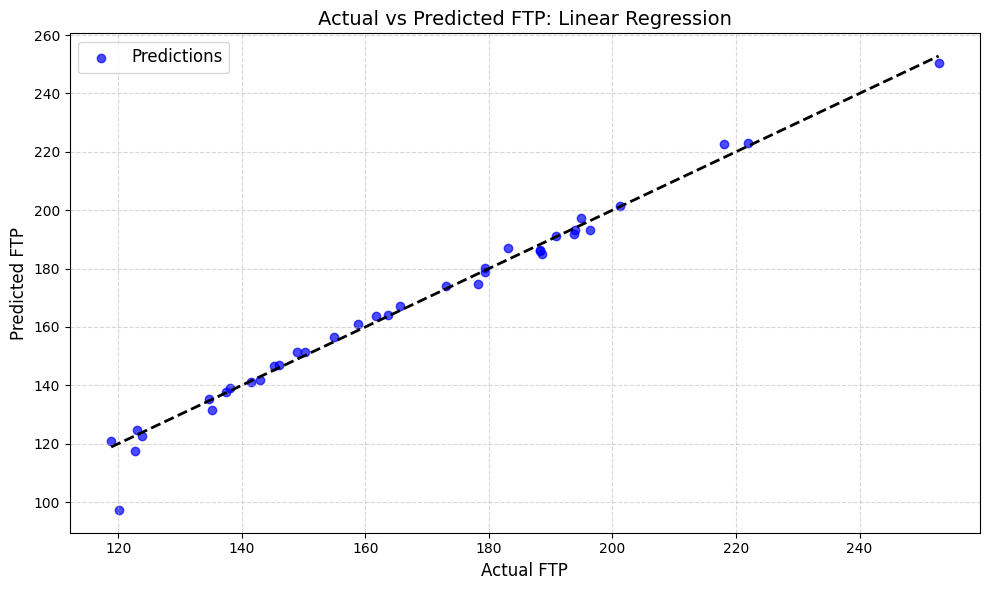

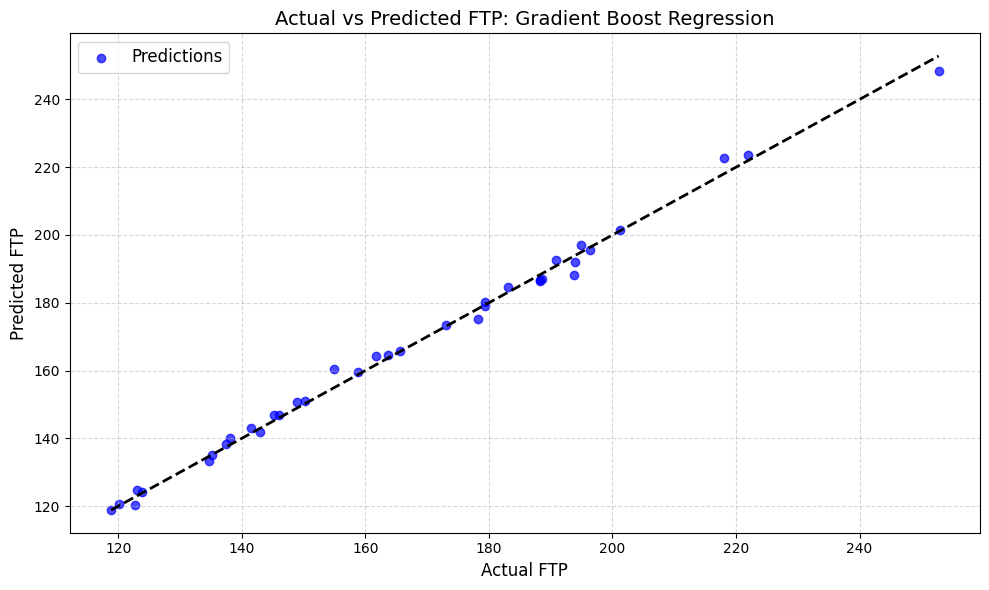

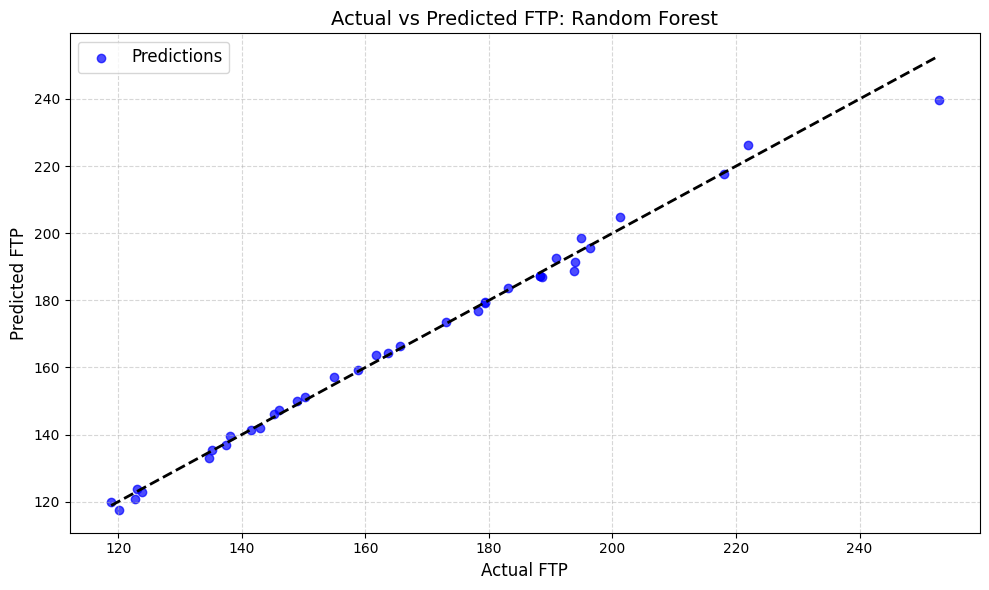

,Model,MSE,R² Score
0,Linear Regression,18.8371,0.9811
1,Gradient Boost Regression,4.6093,0.9954
2,Random Forest,7.9561,0.9920


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the data
data = ftp_values

# Drop any rows where FTP is NaN
data = data.dropna(subset=['FTP'])
data = data.drop(['Activity Date'], axis=1)
data = data.fillna(0)

# Define features (X) and target variable (y)
X = data[input_cols]
y = data['FTP']

# Initialize lists to store results
model_names = []
mse_scores = []
r2_scores = []

# Define a function to evaluate and store results
def evaluate_model(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plot_prediction_results(y_test, y_pred, name)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    model_names.append(name)
    mse_scores.append(mse)
    r2_scores.append(r2)

# Initialize models
models = [
    ("Linear Regression", LinearRegression()),
    ("Gradient Boost Regression", GradientBoostingRegressor()),
    ("Random Forest", RandomForestRegressor())
]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Evaluate each model
for name, model in models:
    evaluate_model(model, name)

# Create a DataFrame to store results
results_df = pd.DataFrame({
    "Model": model_names,
    "MSE": mse_scores,
    "R² Score": r2_scores
})

# Result DataFrame

results_df["MSE"] = results_df["MSE"].apply(lambda x: f"{x:.4f}")
results_df["R² Score"] = results_df["R² Score"].apply(lambda x: f"{x:.4f}")

# Highlight the best-performing model(s)
highlighted_df = results_df.style.apply(lambda x: ['background: lightgreen;color: black' if x.name == 'MSE' and value == x.min() else 'background: lightblue; color: black' if x.name == 'R² Score' and value == x.max() else '' for value in x])

# Print the DataFrame
display(highlighted_df)



**In Summary for this method**,  
Overall, all three models perform well in predicting FTP values. The Gradient Boost Regressor exhibits the lowest Mean Squared Error of 4.70 and the highest R² Score of 0.995, indicating the best performance among the three models. The Linear Regression model showing strong predictive capability with an R² Score of 0.981, while the Random Forest Regressor model also performs well with an R² Score of 0.989.